In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    mean_absolute_percentage_error
)

# ===========================
# 1. DATA LOADING & CLEANING
# ===========================
df = pd.read_excel('Raw_Data_v0.xlsx', engine='openpyxl')
df = df.drop(columns=[
    'Ref#', 'Heat treatment', 'Other RM/Rivet/part cost (€/Part)',
    'Gross Weight (g)', 'Other assembled RM/Rivet/part',
    'Heat Treatment cost (€/Part)', 'Raw Material'
])

num_cols = [
    'Annual target quantity', 'Raw Material Cost (€/kg)', 
    'Thickness (mm)', 'Part Net Weight (g)', 
    'Surface Treatment cost (€/Part)', 'Final Raw Material cost (€/Part)'
]
cat_cols = ['Production', 'Raw Material Designation', 'Surface Treatment']
TARGET = 'Total cost with amortization (€/part)'

df[num_cols] = df[num_cols].fillna(0)
df[cat_cols] = df[cat_cols].fillna('Missing')

# ===========================
# 2. MODEL DEFINITIONS
# ===========================
base_model = LinearRegression()
residual_models = {
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1),
    'RandomForest': RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42),
    'SVM': SVR(kernel='linear', C=1.0),
    'DecisionTree': DecisionTreeRegressor(max_depth=6, random_state=42),
    'CatBoost': CatBoostRegressor(
        iterations=700, depth=6, silent=True, random_seed=42, 
        subsample=0.7, learning_rate=0.02, min_data_in_leaf=30, grow_policy='Depthwise'
    )
}

# ===========================
# 3. CROSS-VALIDATION
# ===========================
kf = KFold(n_splits=3, shuffle=True, random_state=42)
base_results = []
residual_results = []
combined_results = []

for fold, (train_idx, test_idx) in enumerate(kf.split(df), 1):
    X_train, X_test = df.iloc[train_idx], df.iloc[test_idx]
    y_train, y_test = X_train[TARGET], X_test[TARGET]
    
    # --- BASE LINEAR REGRESSION ---
    base_model.fit(X_train[['Final Raw Material cost (€/Part)']], y_train)
    base_pred = base_model.predict(X_test[['Final Raw Material cost (€/Part)']])
    coef = base_model.coef_[0]
    intercept = base_model.intercept_
    base_results.append({
        'Model': 'BaseLinearRegression',
        'Fold': fold,
        'Coefficient': coef,
        'Intercept': intercept,
        'R2': r2_score(y_test, base_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, base_pred)),
        'MAE': mean_absolute_error(y_test, base_pred),
        'MAPE': mean_absolute_percentage_error(y_test, base_pred)
    })
    
    # --- RESIDUALS ---
    residuals_train = y_train - base_model.predict(X_train[['Final Raw Material cost (€/Part)']])
    residuals_test = y_test - base_pred
    X_resid_train = X_train.drop(columns=[TARGET, 'Final Raw Material cost (€/Part)'])
    X_resid_test = X_test.drop(columns=[TARGET, 'Final Raw Material cost (€/Part)'])
    
    # --- RESIDUAL MODEL PIPELINE ---
    preprocessor = ColumnTransformer([
        ('num', RobustScaler(), [col for col in num_cols if col != 'Final Raw Material cost (€/Part)']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ])
    
    for model_name, model in residual_models.items():
        pipe = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])
        try:
            pipe.fit(X_resid_train, residuals_train)
            resid_pred = pipe.predict(X_resid_test)
            # Residual model metrics
            residual_results.append({
                'Model': f'{model_name}_Residuals',
                'Fold': fold,
                'R2': r2_score(residuals_test, resid_pred),
                'RMSE': np.sqrt(mean_squared_error(residuals_test, resid_pred)),
                'MAE': mean_absolute_error(residuals_test, resid_pred),
                'MAPE': mean_absolute_percentage_error(residuals_test, resid_pred)
            })
            # Combined prediction metrics
            combined_pred = base_pred + resid_pred
            combined_results.append({
                'Model': f'Combined_{model_name}',
                'Fold': fold,
                'R2': r2_score(y_test, combined_pred),
                'RMSE': np.sqrt(mean_squared_error(y_test, combined_pred)),
                'MAE': mean_absolute_error(y_test, combined_pred),
                'MAPE': mean_absolute_percentage_error(y_test, combined_pred)
            })
        except Exception as e:
            print(f"Error in {model_name} (Fold {fold}): {str(e)[:100]}")
            continue

# ===========================
# 4. METRICS TABLES
# ===========================
def format_metrics_table(results_list, include_coeffs=False):
    if not results_list:
        return pd.DataFrame()
    df = pd.DataFrame(results_list)
    columns = ['Coefficient', 'Intercept', 'R2', 'RMSE', 'MAE', 'MAPE'] if include_coeffs else ['R2', 'RMSE', 'MAE', 'MAPE']
    columns = [col for col in columns if col in df.columns]
    summary = df.groupby('Model').agg({col: ['mean', 'std'] for col in columns})
    formatted = pd.DataFrame()
    for col in columns:
        formatted[col] = summary[col]['mean'].round(4).astype(str) + ' ± ' + summary[col]['std'].round(4).astype(str)
    return formatted.reset_index()

pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', None)

print("\n" + "="*70)
print("BASE LINEAR REGRESSION PERFORMANCE")
print("="*70)
print(format_metrics_table(base_results, include_coeffs=True).to_string(index=False))

print("\n\n" + "="*70)
print("RESIDUAL MODELS PERFORMANCE")
print("="*70)
print(format_metrics_table(residual_results).to_string(index=False))

print("\n\n" + "="*70)
print("COMBINED MODELS PERFORMANCE")
print("="*70)
print(format_metrics_table(combined_results).to_string(index=False))



BASE LINEAR REGRESSION PERFORMANCE
               Model    Coefficient       Intercept              R2            RMSE             MAE            MAPE
BaseLinearRegression 1.758 ± 0.0826 0.0413 ± 0.0032 0.8695 ± 0.0629 0.2376 ± 0.0998 0.1155 ± 0.0341 1.2269 ± 0.6103


RESIDUAL MODELS PERFORMANCE
                 Model               R2            RMSE             MAE              MAPE
    CatBoost_Residuals   0.471 ± 0.2487  0.161 ± 0.0522 0.0746 ± 0.0175   6.1012 ± 7.1408
DecisionTree_Residuals -0.0711 ± 0.5076 0.2208 ± 0.0448 0.0973 ± 0.0188  9.0557 ± 12.7575
       Lasso_Residuals  0.4753 ± 0.2266 0.1738 ± 0.0907 0.0904 ± 0.0303   5.2132 ± 6.1316
RandomForest_Residuals  0.5342 ± 0.0807 0.1587 ± 0.0605 0.0781 ± 0.0198    7.508 ± 9.9751
       Ridge_Residuals   0.4266 ± 0.192 0.1711 ± 0.0555 0.0917 ± 0.0212  11.0852 ± 13.847
         SVM_Residuals   0.297 ± 0.3083 0.1864 ± 0.0596 0.1164 ± 0.0242 10.8146 ± 10.9903


COMBINED MODELS PERFORMANCE
                Model              R2     

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    mean_absolute_percentage_error
)

# ===========================
# 1. DATA LOADING & CLEANING
# ===========================
df = pd.read_excel('Raw_Data_v0.xlsx', engine='openpyxl')
df = df.drop(columns=[
    'Ref#', 'Heat treatment', 'Other RM/Rivet/part cost (€/Part)',
    'Gross Weight (g)', 'Other assembled RM/Rivet/part',
    'Heat Treatment cost (€/Part)', 'Raw Material'
])

num_cols = [
    'Annual target quantity', 'Raw Material Cost (€/kg)', 
    'Thickness (mm)', 'Part Net Weight (g)', 
    'Surface Treatment cost (€/Part)', 'Final Raw Material cost (€/Part)'
]
cat_cols = ['Production', 'Raw Material Designation', 'Surface Treatment']
TARGET = 'Total cost with amortization (€/part)'

df[num_cols] = df[num_cols].fillna(0)
df[cat_cols] = df[cat_cols].fillna('Missing')

# ===========================
# 2. MODEL DEFINITIONS
# ===========================
base_model = LinearRegression()
residual_models = {
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1),
    'RandomForest': RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42),
    'SVM': SVR(kernel='linear', C=1.0),
    'DecisionTree': DecisionTreeRegressor(max_depth=6, random_state=42),
    'CatBoost': CatBoostRegressor(
        iterations=700, depth=6, silent=True, random_seed=42, 
        subsample=0.7, learning_rate=0.02, min_data_in_leaf=30, grow_policy='Depthwise'
    )
}

# ===========================
# 3. CROSS-VALIDATION
# ===========================
kf = KFold(n_splits=3, shuffle=True, random_state=42)
base_results = []
residual_results = []
combined_results = []

for fold, (train_idx, test_idx) in enumerate(kf.split(df), 1):
    X_train, X_test = df.iloc[train_idx], df.iloc[test_idx]
    y_train, y_test = X_train[TARGET], X_test[TARGET]
    
    # --- BASE LINEAR REGRESSION ---
    base_model.fit(X_train[['Final Raw Material cost (€/Part)']], y_train)
    base_pred = base_model.predict(X_test[['Final Raw Material cost (€/Part)']])
    reg_coef = base_model.coef_[0]
    intercept = base_model.intercept_
    # Pearson correlation coefficient (between -1 and 1)
    corr_coef = np.corrcoef(X_test['Final Raw Material cost (€/Part)'], y_test)[0,1]
    base_results.append({
        'Model': 'BaseLinearRegression',
        'Fold': fold,
        'Regression_Coefficient': reg_coef,
        'Correlation_Coefficient': corr_coef,
        'Intercept': intercept,
        'R2': r2_score(y_test, base_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, base_pred)),
        'MAE': mean_absolute_error(y_test, base_pred),
        'MAPE': mean_absolute_percentage_error(y_test, base_pred)
    })
    
    # --- RESIDUALS ---
    residuals_train = y_train - base_model.predict(X_train[['Final Raw Material cost (€/Part)']])
    residuals_test = y_test - base_pred
    X_resid_train = X_train.drop(columns=[TARGET, 'Final Raw Material cost (€/Part)'])
    X_resid_test = X_test.drop(columns=[TARGET, 'Final Raw Material cost (€/Part)'])
    
    # --- RESIDUAL MODEL PIPELINE ---
    preprocessor = ColumnTransformer([
        ('num', RobustScaler(), [col for col in num_cols if col != 'Final Raw Material cost (€/Part)']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ])
    
    for model_name, model in residual_models.items():
        pipe = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])
        try:
            pipe.fit(X_resid_train, residuals_train)
            resid_pred = pipe.predict(X_resid_test)
            # Residual model metrics
            residual_results.append({
                'Model': f'{model_name}_Residuals',
                'Fold': fold,
                'R2': r2_score(residuals_test, resid_pred),
                'RMSE': np.sqrt(mean_squared_error(residuals_test, resid_pred)),
                'MAE': mean_absolute_error(residuals_test, resid_pred),
                'MAPE': mean_absolute_percentage_error(residuals_test, resid_pred)
            })
            # Combined prediction metrics
            combined_pred = base_pred + resid_pred
            combined_results.append({
                'Model': f'Combined_{model_name}',
                'Fold': fold,
                'R2': r2_score(y_test, combined_pred),
                'RMSE': np.sqrt(mean_squared_error(y_test, combined_pred)),
                'MAE': mean_absolute_error(y_test, combined_pred),
                'MAPE': mean_absolute_percentage_error(y_test, combined_pred)
            })
        except Exception as e:
            print(f"Error in {model_name} (Fold {fold}): {str(e)[:100]}")
            continue

# ===========================
# 4. METRICS TABLES
# ===========================
def format_metrics_table(results_list, include_coeffs=False):
    if not results_list:
        return pd.DataFrame()
    df = pd.DataFrame(results_list)
    columns = ['Regression_Coefficient', 'Correlation_Coefficient', 'Intercept', 'R2', 'RMSE', 'MAE', 'MAPE'] if include_coeffs else ['R2', 'RMSE', 'MAE', 'MAPE']
    columns = [col for col in columns if col in df.columns]
    summary = df.groupby('Model').agg({col: ['mean', 'std'] for col in columns})
    formatted = pd.DataFrame()
    for col in columns:
        formatted[col] = summary[col]['mean'].round(4).astype(str) + ' ± ' + summary[col]['std'].round(4).astype(str)
    return formatted.reset_index()

pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', None)

print("\n" + "="*70)
print("BASE LINEAR REGRESSION PERFORMANCE")
print("="*70)
print(format_metrics_table(base_results, include_coeffs=True).to_string(index=False))

print("\n\n" + "="*70)
print("RESIDUAL MODELS PERFORMANCE")
print("="*70)
print(format_metrics_table(residual_results).to_string(index=False))

print("\n\n" + "="*70)
print("COMBINED MODELS PERFORMANCE")
print("="*70)
print(format_metrics_table(combined_results).to_string(index=False))



BASE LINEAR REGRESSION PERFORMANCE
               Model Regression_Coefficient Correlation_Coefficient       Intercept              R2            RMSE             MAE            MAPE
BaseLinearRegression         1.758 ± 0.0826         0.9409 ± 0.0307 0.0413 ± 0.0032 0.8695 ± 0.0629 0.2376 ± 0.0998 0.1155 ± 0.0341 1.2269 ± 0.6103


RESIDUAL MODELS PERFORMANCE
                 Model               R2            RMSE             MAE              MAPE
    CatBoost_Residuals   0.471 ± 0.2487  0.161 ± 0.0522 0.0746 ± 0.0175   6.1012 ± 7.1408
DecisionTree_Residuals -0.0711 ± 0.5076 0.2208 ± 0.0448 0.0973 ± 0.0188  9.0557 ± 12.7575
       Lasso_Residuals  0.4753 ± 0.2266 0.1738 ± 0.0907 0.0904 ± 0.0303   5.2132 ± 6.1316
RandomForest_Residuals  0.5342 ± 0.0807 0.1587 ± 0.0605 0.0781 ± 0.0198    7.508 ± 9.9751
       Ridge_Residuals   0.4266 ± 0.192 0.1711 ± 0.0555 0.0917 ± 0.0212  11.0852 ± 13.847
         SVM_Residuals   0.297 ± 0.3083 0.1864 ± 0.0596 0.1164 ± 0.0242 10.8146 ± 10.9903


COMBIN

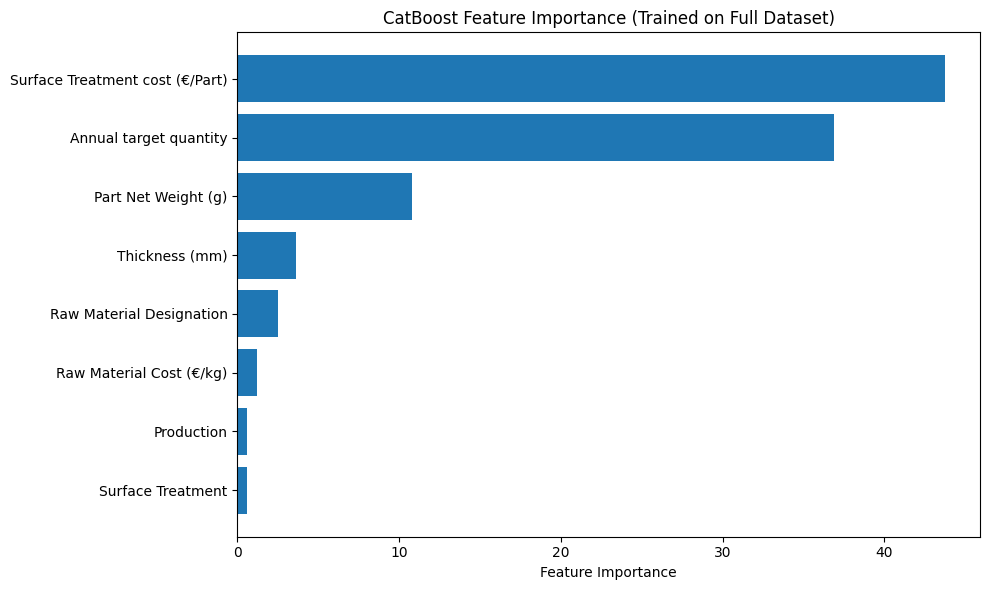


BASE LINEAR REGRESSION PERFORMANCE
               Model Regression_Coefficient Correlation_Coefficient       Intercept              R2            RMSE             MAE            MAPE
BaseLinearRegression         1.758 ± 0.0826         0.9409 ± 0.0307 0.0413 ± 0.0032 0.8695 ± 0.0629 0.2376 ± 0.0998 0.1155 ± 0.0341 1.2269 ± 0.6103


RESIDUAL MODEL PERFORMANCE (CatBoost Only)
             Model             R2            RMSE             MAE            MAPE
CatBoost_Residuals 0.501 ± 0.2231 0.1567 ± 0.0499 0.0761 ± 0.0135 8.0354 ± 9.4669


COMBINED MODEL PERFORMANCE (Base + CatBoost)
            Model              R2            RMSE             MAE            MAPE
Combined_CatBoost 0.9448 ± 0.0044 0.1567 ± 0.0499 0.0761 ± 0.0135 0.7914 ± 0.4768


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    mean_absolute_percentage_error
)

# ===========================
# 1. DATA LOADING & CLEANING
# ===========================
df = pd.read_excel('Raw_Data_v0.xlsx', engine='openpyxl')
df = df.drop(columns=[
    'Ref#', 'Heat treatment', 'Other RM/Rivet/part cost (€/Part)',
    'Gross Weight (g)', 'Other assembled RM/Rivet/part',
    'Heat Treatment cost (€/Part)', 'Raw Material'
])

num_cols = [
    'Annual target quantity', 'Raw Material Cost (€/kg)', 
    'Thickness (mm)', 'Part Net Weight (g)', 
    'Surface Treatment cost (€/Part)', 'Final Raw Material cost (€/Part)'
]
cat_cols = ['Production', 'Raw Material Designation', 'Surface Treatment']
TARGET = 'Total cost with amortization (€/part)'

df[num_cols] = df[num_cols].fillna(0)
df[cat_cols] = df[cat_cols].fillna('Missing')

# ===========================
# 2. MODEL DEFINITIONS
# ===========================
base_model = LinearRegression()
residual_model = CatBoostRegressor(
    iterations=700, depth=6, silent=True, random_seed=42, 
    subsample=0.7, learning_rate=0.02, min_data_in_leaf=30, grow_policy='Depthwise'
)

# ===========================
# 3. CROSS-VALIDATION
# ===========================
kf = KFold(n_splits=3, shuffle=True, random_state=42)
base_results = []
residual_results = []
combined_results = []

for fold, (train_idx, test_idx) in enumerate(kf.split(df), 1):
    X_train, X_test = df.iloc[train_idx], df.iloc[test_idx]
    y_train, y_test = X_train[TARGET], X_test[TARGET]
    
    # --- BASE LINEAR REGRESSION ---
    base_model.fit(X_train[['Final Raw Material cost (€/Part)']], y_train)
    base_pred = base_model.predict(X_test[['Final Raw Material cost (€/Part)']])
    reg_coef = base_model.coef_[0]
    intercept = base_model.intercept_
    corr_coef = np.corrcoef(X_test['Final Raw Material cost (€/Part)'], y_test)[0,1]
    base_results.append({
        'Model': 'BaseLinearRegression',
        'Fold': fold,
        'Regression_Coefficient': reg_coef,
        'Correlation_Coefficient': corr_coef,
        'Intercept': intercept,
        'R2': r2_score(y_test, base_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, base_pred)),
        'MAE': mean_absolute_error(y_test, base_pred),
        'MAPE': mean_absolute_percentage_error(y_test, base_pred)
    })
    
    # --- RESIDUALS ---
    residuals_train = y_train - base_model.predict(X_train[['Final Raw Material cost (€/Part)']])
    residuals_test = y_test - base_pred
    X_resid_train = X_train.drop(columns=[TARGET, 'Final Raw Material cost (€/Part)'])
    X_resid_test = X_test.drop(columns=[TARGET, 'Final Raw Material cost (€/Part)'])

    cat_features_idx = [X_resid_train.columns.get_loc(col) for col in cat_cols]
    catboost_model = residual_model.fit(X_resid_train, residuals_train, cat_features=cat_features_idx)
    resid_pred = catboost_model.predict(X_resid_test)
    
    residual_results.append({
        'Model': 'CatBoost_Residuals',
        'Fold': fold,
        'R2': r2_score(residuals_test, resid_pred),
        'RMSE': np.sqrt(mean_squared_error(residuals_test, resid_pred)),
        'MAE': mean_absolute_error(residuals_test, resid_pred),
        'MAPE': mean_absolute_percentage_error(residuals_test, resid_pred)
    })
    
    combined_pred = base_pred + resid_pred
    combined_results.append({
        'Model': 'Combined_CatBoost',
        'Fold': fold,
        'R2': r2_score(y_test, combined_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, combined_pred)),
        'MAE': mean_absolute_error(y_test, combined_pred),
        'MAPE': mean_absolute_percentage_error(y_test, combined_pred)
    })

# ===========================
# 4. FINAL CATBOOST FOR FEATURE IMPORTANCE
# ===========================
# Use full dataset for final model
X_resid_full = df.drop(columns=[TARGET, 'Final Raw Material cost (€/Part)'])
residuals_full = df[TARGET] - base_model.predict(df[['Final Raw Material cost (€/Part)']])
cat_features_idx = [X_resid_full.columns.get_loc(col) for col in cat_cols]

final_catboost_model = residual_model.fit(X_resid_full, residuals_full, cat_features=cat_features_idx)

# Plot feature importances
feature_importances = final_catboost_model.get_feature_importance()
feature_names = X_resid_full.columns
sorted_idx = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importances)), feature_importances[sorted_idx])
plt.yticks(range(len(feature_importances)), feature_names[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("CatBoost Feature Importance (Trained on Full Dataset)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# ===========================
# 5. METRICS TABLES
# ===========================
def format_metrics_table(results_list, include_coeffs=False):
    if not results_list:
        return pd.DataFrame()
    df = pd.DataFrame(results_list)
    columns = ['Regression_Coefficient', 'Correlation_Coefficient', 'Intercept', 'R2', 'RMSE', 'MAE', 'MAPE'] if include_coeffs else ['R2', 'RMSE', 'MAE', 'MAPE']
    columns = [col for col in columns if col in df.columns]
    summary = df.groupby('Model').agg({col: ['mean', 'std'] for col in columns})
    formatted = pd.DataFrame()
    for col in columns:
        formatted[col] = summary[col]['mean'].round(4).astype(str) + ' ± ' + summary[col]['std'].round(4).astype(str)
    return formatted.reset_index()

pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', None)

print("\n" + "="*70)
print("BASE LINEAR REGRESSION PERFORMANCE")
print("="*70)
print(format_metrics_table(base_results, include_coeffs=True).to_string(index=False))

print("\n\n" + "="*70)
print("RESIDUAL MODEL PERFORMANCE (CatBoost Only)")
print("="*70)
print(format_metrics_table(residual_results).to_string(index=False))

print("\n\n" + "="*70)
print("COMBINED MODEL PERFORMANCE (Base + CatBoost)")
print("="*70)
print(format_metrics_table(combined_results).to_string(index=False))


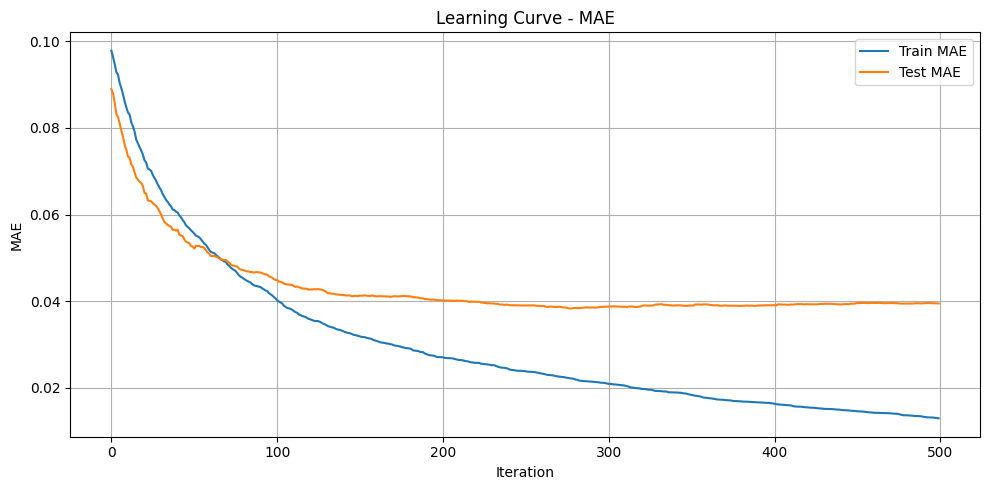


FINAL COMBINED MODEL METRICS
R2: 0.9621
RMSE: 0.0726
MAE: 0.0395
MAPE: 0.4592
Within ±10%: 0.3438


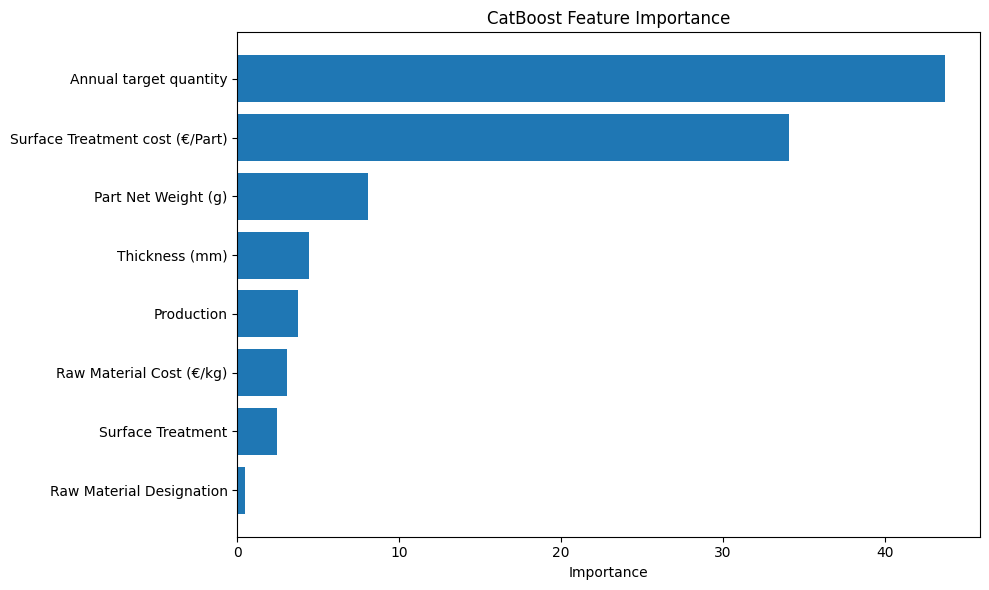

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
)

# ===========================
# 1. Load and Clean Data
# ===========================
df = pd.read_excel('Raw_Data_v0.xlsx', engine='openpyxl')
df = df.drop(columns=[
    'Ref#', 'Heat treatment', 'Other RM/Rivet/part cost (€/Part)',
    'Gross Weight (g)', 'Other assembled RM/Rivet/part',
    'Heat Treatment cost (€/Part)', 'Raw Material'
])

num_cols = [
    'Annual target quantity', 'Raw Material Cost (€/kg)', 
    'Thickness (mm)', 'Part Net Weight (g)', 
    'Surface Treatment cost (€/Part)', 'Final Raw Material cost (€/Part)'
]
cat_cols = ['Production', 'Raw Material Designation', 'Surface Treatment']
TARGET = 'Total cost with amortization (€/part)'

df[num_cols] = df[num_cols].fillna(0)
df[cat_cols] = df[cat_cols].fillna('Missing')
df = df[df[TARGET] <= 3].reset_index(drop=True)

# ===========================
# 2. Baseline and Residuals
# ===========================
base_model = LinearRegression()
base_model.fit(df[['Final Raw Material cost (€/Part)']], df[TARGET])
base_preds = base_model.predict(df[['Final Raw Material cost (€/Part)']])
residuals = df[TARGET] - base_preds

X_resid = df.drop(columns=[TARGET, 'Final Raw Material cost (€/Part)'])
cat_features_idx = [X_resid.columns.get_loc(col) for col in cat_cols]

# ===========================
# 3. Hyperparameter Tuning
# ===========================
param_grid = {
    'depth': [4, 5, 6],
    'learning_rate': [0.03, 0.05],
    'l2_leaf_reg': [1, 3]
}
kf = KFold(n_splits=3, shuffle=True, random_state=42)
best_score = -np.inf
best_params = {}

for depth, lr, l2 in product(param_grid['depth'], param_grid['learning_rate'], param_grid['l2_leaf_reg']):
    scores = []
    for train_idx, val_idx in kf.split(X_resid):
        X_train, X_val = X_resid.iloc[train_idx], X_resid.iloc[val_idx]
        y_train, y_val = residuals.iloc[train_idx], residuals.iloc[val_idx]

        model = CatBoostRegressor(
            iterations=500,
            depth=depth,
            learning_rate=lr,
            l2_leaf_reg=l2,
            silent=True,
            random_seed=42,
            cat_features=cat_features_idx
        )
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        scores.append(r2_score(y_val, preds))
    
    avg_score = np.mean(scores)
    if avg_score > best_score:
        best_score = avg_score
        best_params = {'depth': depth, 'learning_rate': lr, 'l2_leaf_reg': l2}

# ===========================
# 4. Final Training + Metrics
# ===========================
X_train, X_test, y_train, y_test, base_train, base_test = train_test_split(
    X_resid, residuals, base_preds, test_size=0.2, random_state=42
)

final_model = CatBoostRegressor(
    iterations=500,
    depth=best_params['depth'],
    learning_rate=best_params['learning_rate'],
    l2_leaf_reg=best_params['l2_leaf_reg'],
    eval_metric='MAE',
    silent=True,
    random_seed=42,
    cat_features=cat_features_idx
)

final_model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    use_best_model=False,
    verbose=False
)

# ===========================
# 5. Evaluation + Learning Curve
# ===========================
evals_result = final_model.get_evals_result()
train_mae = evals_result['learn']['MAE']
test_mae = evals_result['validation']['MAE']

plt.figure(figsize=(10, 5))
plt.plot(train_mae, label='Train MAE')
plt.plot(test_mae, label='Test MAE')
plt.xlabel('Iteration')
plt.ylabel('MAE')
plt.title('Learning Curve - MAE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ===========================
# 6. Final Evaluation
# ===========================
resid_pred = final_model.predict(X_test)
combined_pred = base_test + resid_pred
true_values = base_test + y_test

metrics = {
    'R2': round(r2_score(true_values, combined_pred), 4),
    'RMSE': round(np.sqrt(mean_squared_error(true_values, combined_pred)), 4),
    'MAE': round(mean_absolute_error(true_values, combined_pred), 4),
    'MAPE': round(mean_absolute_percentage_error(true_values, combined_pred), 4),
    'Within ±10%': round(np.mean(np.abs(combined_pred - true_values) / true_values <= 0.10), 4)
}

print("\n" + "="*70)
print("FINAL COMBINED MODEL METRICS")
print("="*70)
for k, v in metrics.items():
    print(f"{k}: {v}")

# ===========================
# 7. Feature Importance
# ===========================
importances = final_model.get_feature_importance()
feature_names = X_resid.columns
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.barh(feature_names[sorted_idx], importances[sorted_idx])
plt.gca().invert_yaxis()
plt.title("CatBoost Feature Importance")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


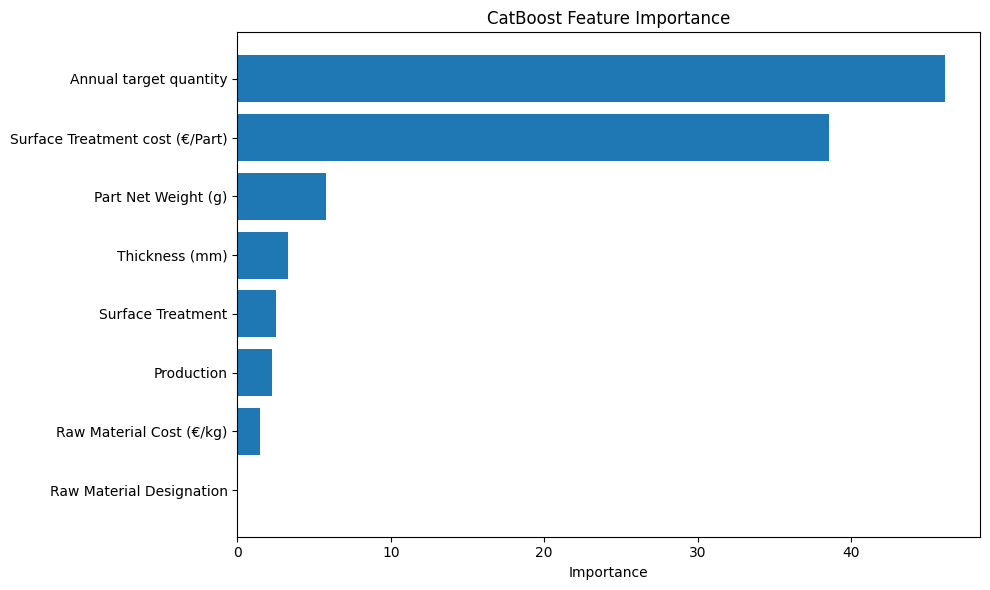

Best hyperparameters (min RMSE): {'depth': 4, 'learning_rate': 0.05, 'l2_leaf_reg': 3}


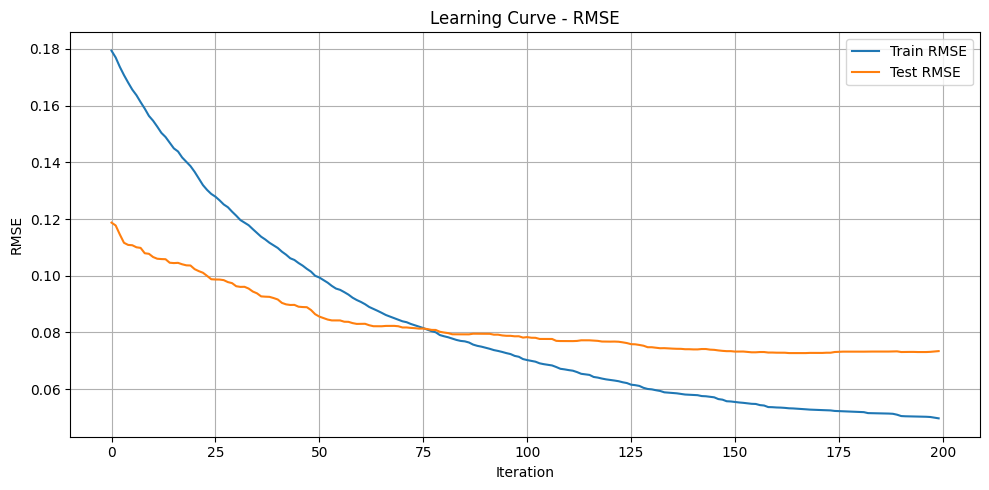


FINAL COMBINED MODEL METRICS (Train/Test Split)
R2: 0.9613
RMSE: 0.0734
MAE: 0.0422
MAPE: 0.7944
Within ±10%: 0.2812

FINAL COMBINED MODEL METRICS (3-Fold CV)
R2: 0.9349
RMSE: 0.0997
MAE: 0.0513
MAPE: 0.558
Within ±10%: 0.2436


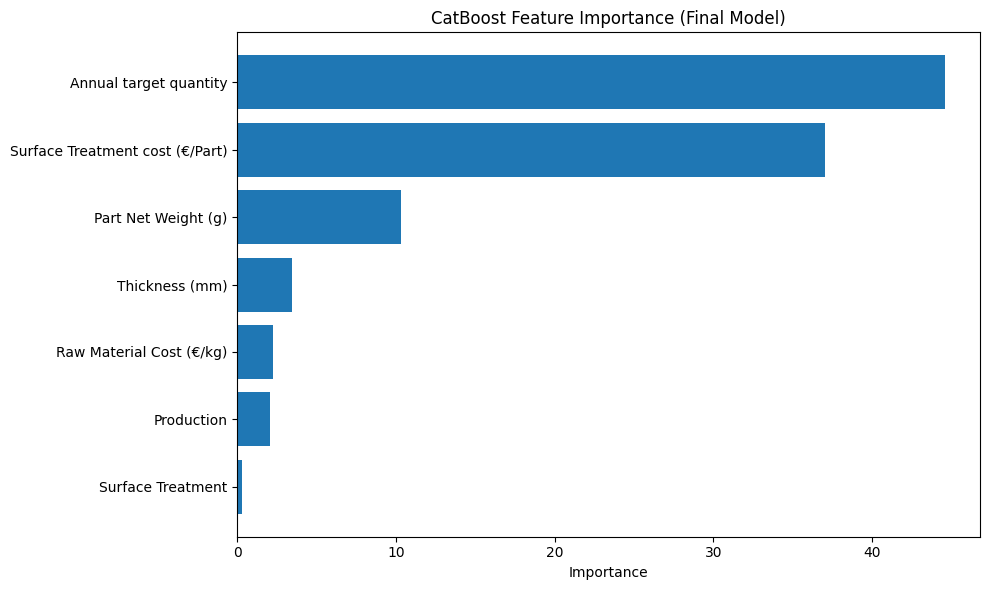

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
)

# ===========================
# 1. Load and Clean Data
# ===========================
df = pd.read_excel('Raw_Data_v0.xlsx', engine='openpyxl')
df = df.drop(columns=[
    'Ref#', 'Heat treatment', 'Other RM/Rivet/part cost (€/Part)',
    'Gross Weight (g)', 'Other assembled RM/Rivet/part' ,'Heat Treatment cost (€/Part)', 'Raw Material'
])

num_cols = [
    'Annual target quantity', 'Raw Material Cost (€/kg)', 
    'Thickness (mm)', 'Part Net Weight (g)', 
    'Surface Treatment cost (€/Part)', 'Final Raw Material cost (€/Part)',
]
cat_cols = ['Production', 'Raw Material Designation', 'Surface Treatment']
TARGET = 'Total cost with amortization (€/part)'

df[num_cols] = df[num_cols].fillna(0)
df[cat_cols] = df[cat_cols].fillna('Missing')
df = df[df[TARGET] <= 3].reset_index(drop=True)

# ===========================
# 2. Baseline and Residuals
# ===========================
base_model = LinearRegression()
base_model.fit(df[['Final Raw Material cost (€/Part)']], df[TARGET])
base_preds = base_model.predict(df[['Final Raw Material cost (€/Part)']])
residuals = df[TARGET] - base_preds

# Prepare features for residual model
X_resid = df.drop(columns=[TARGET, 'Final Raw Material cost (€/Part)'])
cat_features_idx = [X_resid.columns.get_loc(col) for col in cat_cols]

# ===========================
# 3. Feature Selection (Optional)
# ===========================
# Train a quick CatBoost to get feature importances
temp_model = CatBoostRegressor(
    iterations=100, depth=4, learning_rate=0.05, silent=True, cat_features=cat_features_idx
)
temp_model.fit(X_resid, residuals)
importances = temp_model.get_feature_importance()
feature_names = X_resid.columns
sorted_idx = np.argsort(importances)[::-1]

# Visualize importances
plt.figure(figsize=(10, 6))
plt.barh(feature_names[sorted_idx], importances[sorted_idx])
plt.gca().invert_yaxis()
plt.title("CatBoost Feature Importance")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# Remove features with very low importance (<1% of total importance)
importance_threshold = 0.01 * importances.sum()
important_features = feature_names[importances > importance_threshold]
X_resid = X_resid[important_features]
cat_features_idx = [X_resid.columns.get_loc(col) for col in cat_cols if col in X_resid.columns]

# ===========================
# 4. Hyperparameter Tuning (for RMSE)
# ===========================
param_grid = {
    'depth': [4, 5, 6],
    'learning_rate': [0.03, 0.05],
    'l2_leaf_reg': [1, 3]
}
kf = KFold(n_splits=3, shuffle=True, random_state=42)
best_score = np.inf
best_params = {}

for depth, lr, l2 in product(param_grid['depth'], param_grid['learning_rate'], param_grid['l2_leaf_reg']):
    scores = []
    for train_idx, val_idx in kf.split(X_resid):
        X_train, X_val = X_resid.iloc[train_idx], X_resid.iloc[val_idx]
        y_train, y_val = residuals.iloc[train_idx], residuals.iloc[val_idx]

        model = CatBoostRegressor(
            iterations=200,  # Reduced based on learning curve
            depth=depth,
            learning_rate=lr,
            l2_leaf_reg=l2,
            silent=True,
            random_seed=42,
            cat_features=cat_features_idx,
            eval_metric='RMSE'
        )
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        scores.append(np.sqrt(mean_squared_error(y_val, preds)))
    
    avg_score = np.mean(scores)
    if avg_score < best_score:
        best_score = avg_score
        best_params = {'depth': depth, 'learning_rate': lr, 'l2_leaf_reg': l2}

print("Best hyperparameters (min RMSE):", best_params)

# ===========================
# 5. Final Training + Learning Curve
# ===========================
X_train, X_test, y_train, y_test, base_train, base_test = train_test_split(
    X_resid, residuals, base_preds, test_size=0.2, random_state=42
)

final_model = CatBoostRegressor(
    iterations=200,
    depth=best_params['depth'],
    learning_rate=best_params['learning_rate'],
    l2_leaf_reg=best_params['l2_leaf_reg'],
    eval_metric='RMSE',
    silent=True,
    random_seed=42,
    cat_features=cat_features_idx
)

final_model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    use_best_model=False,
    verbose=False
)

evals_result = final_model.get_evals_result()
train_rmse = evals_result['learn']['RMSE']
test_rmse = evals_result['validation']['RMSE']

plt.figure(figsize=(10, 5))
plt.plot(train_rmse, label='Train RMSE')
plt.plot(test_rmse, label='Test RMSE')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('Learning Curve - RMSE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ===========================
# 6. Final Evaluation (Train/Test Split)
# ===========================
resid_pred = final_model.predict(X_test)
combined_pred = base_test + resid_pred
true_values = base_test + y_test

metrics = {
    'R2': round(r2_score(true_values, combined_pred), 4),
    'RMSE': round(np.sqrt(mean_squared_error(true_values, combined_pred)), 4),
    'MAE': round(mean_absolute_error(true_values, combined_pred), 4),
    'MAPE': round(mean_absolute_percentage_error(true_values, combined_pred), 4),
    'Within ±10%': round(np.mean(np.abs(combined_pred - true_values) / true_values <= 0.10), 4)
}

print("\n" + "="*70)
print("FINAL COMBINED MODEL METRICS (Train/Test Split)")
print("="*70)
for k, v in metrics.items():
    print(f"{k}: {v}")

# ===========================
# 7. 3-Fold Cross-Validation on Final Model
# ===========================
metrics_list = []

for train_idx, test_idx in kf.split(X_resid):
    X_train, X_test = X_resid.iloc[train_idx], X_resid.iloc[test_idx]
    y_train, y_test = residuals.iloc[train_idx], residuals.iloc[test_idx]
    base_train, base_test = base_preds[train_idx], base_preds[test_idx]

    model = CatBoostRegressor(
        iterations=200,
        depth=best_params['depth'],
        learning_rate=best_params['learning_rate'],
        l2_leaf_reg=best_params['l2_leaf_reg'],
        silent=True,
        random_seed=42,
        cat_features=cat_features_idx,
        eval_metric='RMSE'
    )
    model.fit(X_train, y_train)
    resid_pred = model.predict(X_test)
    combined_pred = base_test + resid_pred
    true_values = base_test + y_test

    metrics_list.append({
        'R2': r2_score(true_values, combined_pred),
        'RMSE': np.sqrt(mean_squared_error(true_values, combined_pred)),
        'MAE': mean_absolute_error(true_values, combined_pred),
        'MAPE': mean_absolute_percentage_error(true_values, combined_pred),
        'Within ±10%': np.mean(np.abs(combined_pred - true_values) / true_values <= 0.10)
    })

cv_metrics = pd.DataFrame(metrics_list).mean()
print("\n" + "="*70)
print("FINAL COMBINED MODEL METRICS (3-Fold CV)")
print("="*70)
for k, v in cv_metrics.items():
    print(f"{k}: {round(v, 4)}")

# ===========================
# 8. Feature Importance (Final Model)
# ===========================
importances = final_model.get_feature_importance()
feature_names = X_resid.columns
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.barh(feature_names[sorted_idx], importances[sorted_idx])
plt.gca().invert_yaxis()
plt.title("CatBoost Feature Importance (Final Model)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


[I 2025-05-22 23:19:59,453] A new study created in memory with name: no-name-f077b2a3-6507-476e-83d7-d7a3648c5e5d
[I 2025-05-22 23:20:04,416] Trial 0 finished with value: 0.15235733899221168 and parameters: {'learning_rate': 0.05125194741776151, 'depth': 7, 'l2_leaf_reg': 1.0168183400278226, 'random_strength': 2.246943005882928, 'bagging_temperature': 6.180528942934656, 'subsample': 0.6023993201485721, 'colsample_bylevel': 0.7824656697543086, 'min_data_in_leaf': 2, 'grow_policy': 'Depthwise'}. Best is trial 0 with value: 0.15235733899221168.
[I 2025-05-22 23:20:15,233] Trial 1 finished with value: 0.09279958439568681 and parameters: {'learning_rate': 0.08360801415323144, 'depth': 8, 'l2_leaf_reg': 8.770585751964568, 'random_strength': 0.49155098841502626, 'bagging_temperature': 2.7694193955744084, 'subsample': 0.7221957449483156, 'colsample_bylevel': 0.9174490199334484, 'min_data_in_leaf': 24, 'grow_policy': 'Depthwise'}. Best is trial 1 with value: 0.09279958439568681.
[I 2025-05-22 2

Best hyperparameters: {'learning_rate': 0.08890643163221275, 'depth': 7, 'l2_leaf_reg': 5.562226271385976, 'random_strength': 0.2746589411488074, 'bagging_temperature': 3.1895336912967, 'subsample': 0.8902825234568688, 'colsample_bylevel': 0.903027652087251, 'min_data_in_leaf': 29, 'grow_policy': 'Lossguide'}
Best RMSE: 0.08814217681119314


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.1770509	test: 0.1163725	best: 0.1163725 (0)	total: 33.4ms	remaining: 33.4s
1:	learn: 0.1724404	test: 0.1108131	best: 0.1108131 (1)	total: 61.3ms	remaining: 30.6s
2:	learn: 0.1680805	test: 0.1058223	best: 0.1058223 (2)	total: 93.4ms	remaining: 31s
3:	learn: 0.1641131	test: 0.1013109	best: 0.1013109 (3)	total: 132ms	remaining: 32.8s
4:	learn: 0.1609074	test: 0.0980036	best: 0.0980036 (4)	total: 157ms	remaining: 31.2s
5:	learn: 0.1573824	test: 0.0968754	best: 0.0968754 (5)	total: 190ms	remaining: 31.5s
6:	learn: 0.1540669	test: 0.0960780	best: 0.0960780 (6)	total: 230ms	remaining: 32.6s
7:	learn: 0.1511303	test: 0.0958326	best: 0.0958326 (7)	total: 260ms	remaining: 32.3s
8:	learn: 0.1475346	test: 0.0938957	best: 0.0938957 (8)	total: 291ms	remaining: 32s
9:	learn: 0.1446784	test: 0.0928604	best: 0.0928604 (9)	total: 326ms	remaining: 32.3s
10:	learn: 0.1417237	test: 0.0899338	best: 0.0899338 (10)	total: 355ms	remaining: 31.9s
11:	learn: 0.1388442	test: 0.0889256	best: 0.0889256 

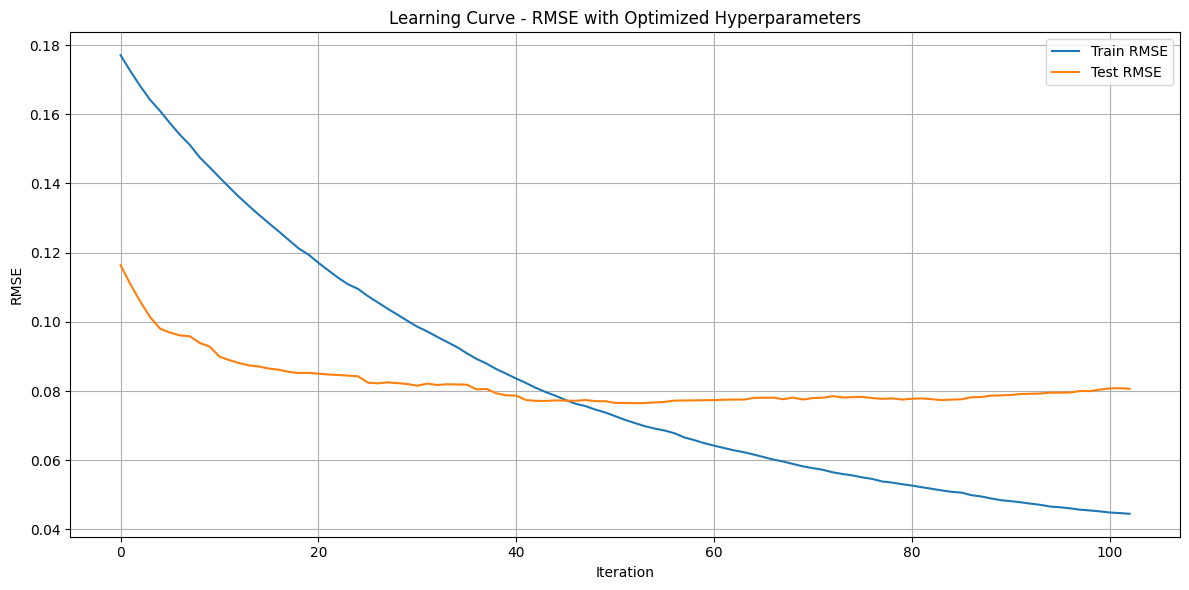


FINAL COMBINED MODEL METRICS (Train/Test Split)
R2: 0.958
RMSE: 0.0765
MAE: 0.0436
MAPE: 0.7069
Within ±10%: 0.25

FINAL COMBINED MODEL METRICS (3-Fold CV)
R2: 0.9364 ± 0.0427
RMSE: 0.0964 ± 0.0265
MAE: 0.0504 ± 0.0126
MAPE: 0.4365 ± 0.035
Within ±10%: 0.2564 ± 0.1159


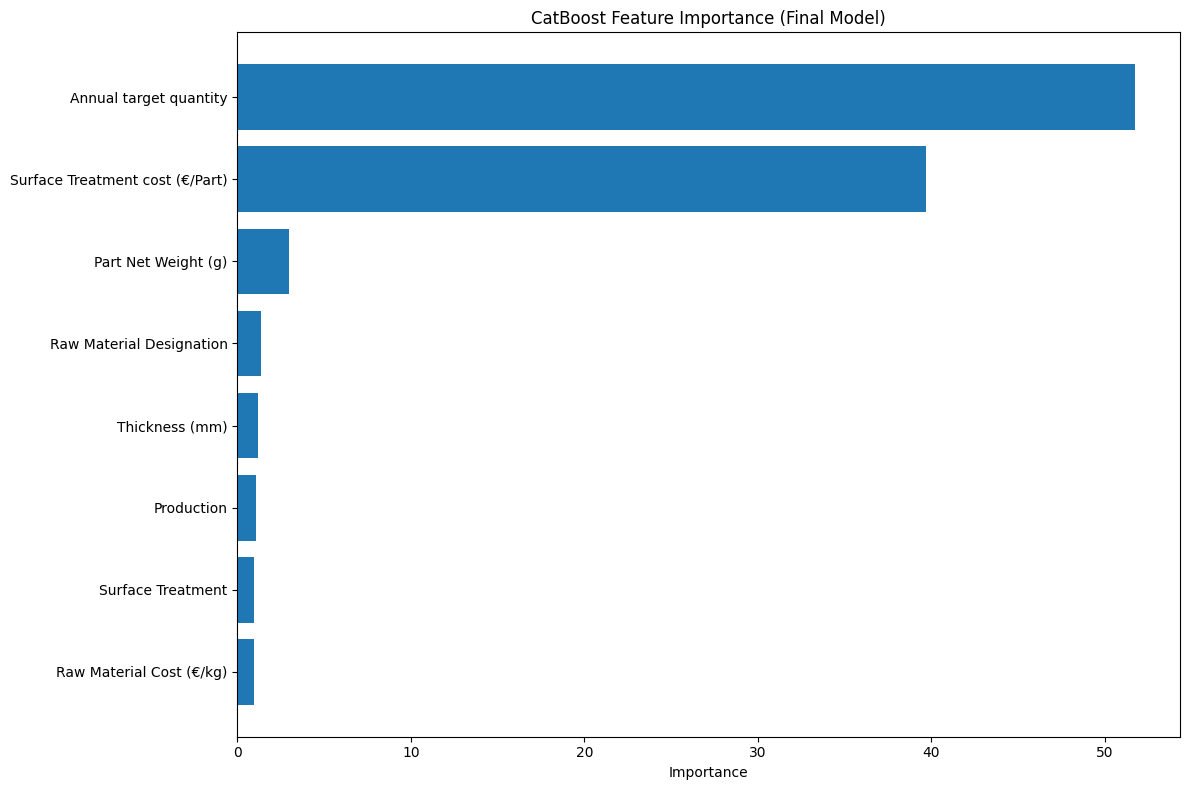


Final model saved as 'optimized_catboost_model.cbm'


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
)
import optuna  # Make sure to install: pip install optuna

# ===========================
# 1. Load and Clean Data
# ===========================
df = pd.read_excel('Raw_Data_v0.xlsx', engine='openpyxl')
df = df.drop(columns=[
    'Ref#', 'Heat treatment', 'Other RM/Rivet/part cost (€/Part)',
    'Gross Weight (g)', 'Other assembled RM/Rivet/part',
    'Heat Treatment cost (€/Part)', 'Raw Material'
])

num_cols = [
    'Annual target quantity', 'Raw Material Cost (€/kg)', 
    'Thickness (mm)', 'Part Net Weight (g)', 
    'Surface Treatment cost (€/Part)', 'Final Raw Material cost (€/Part)'
]
cat_cols = ['Production', 'Raw Material Designation', 'Surface Treatment']
TARGET = 'Total cost with amortization (€/part)'

df[num_cols] = df[num_cols].fillna(0)
df[cat_cols] = df[cat_cols].fillna('Missing')
df = df[df[TARGET] <= 3].reset_index(drop=True)

# ===========================
# 2. Baseline and Residuals
# ===========================
base_model = LinearRegression()
base_model.fit(df[['Final Raw Material cost (€/Part)']], df[TARGET])
base_preds = base_model.predict(df[['Final Raw Material cost (€/Part)']])
residuals = df[TARGET] - base_preds

# Prepare features for residual model
X_resid = df.drop(columns=[TARGET, 'Final Raw Material cost (€/Part)'])
cat_features_idx = [X_resid.columns.get_loc(col) for col in cat_cols]

# Split the data for later use
X_train, X_test, y_train, y_test, base_train, base_test = train_test_split(
    X_resid, residuals, base_preds, test_size=0.2, random_state=42
)

# Create validation set for early stopping
X_train_fit, X_val, y_train_fit, y_val, base_train_fit, base_val = train_test_split(
    X_train, y_train, base_train, test_size=0.2, random_state=42
)

# ===========================
# 3. Optuna Hyperparameter Optimization
# ===========================
def objective(trial):
    # Define the hyperparameter search space
    param = {
        'iterations': 1000,  # Fixed high value, we'll use early stopping
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'random_strength': trial.suggest_float('random_strength', 0.1, 10, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 30),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'eval_metric': 'RMSE',
        'cat_features': cat_features_idx,
        'random_seed': 42
    }
    
    # Create CatBoost model with current hyperparameters
    model = CatBoostRegressor(**param, silent=True)
    
    # Train with early stopping
    train_pool = Pool(X_train_fit, y_train_fit, cat_features=cat_features_idx)
    eval_pool = Pool(X_val, y_val, cat_features=cat_features_idx)
    
    model.fit(
        train_pool, eval_set=eval_pool,
        early_stopping_rounds=50,
        verbose=False,
        use_best_model=True
    )
    
    # Make predictions on validation set
    val_pred = model.predict(X_val)
    combined_pred = base_val + val_pred
    true_values = base_val + y_val
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(true_values, combined_pred))
    
    return rmse

# Create and run the Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)  # Adjust number of trials as needed

# Print the best hyperparameters
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

# ===========================
# 4. Train Final Model with Best Parameters
# ===========================
# Get the best parameters from Optuna
best_params = study.best_params
best_params['iterations'] = 1000  # Set high and rely on early stopping
best_params['eval_metric'] = 'RMSE'
best_params['cat_features'] = cat_features_idx
best_params['random_seed'] = 42

final_model = CatBoostRegressor(**best_params, silent=True)

# Create data pools
train_pool = Pool(X_train, y_train, cat_features=cat_features_idx)
test_pool = Pool(X_test, y_test, cat_features=cat_features_idx)

# Train with early stopping
final_model.fit(
    train_pool, eval_set=test_pool,
    early_stopping_rounds=50,
    verbose=True,
    use_best_model=True,
    plot=True  # Will generate the learning curve if in interactive environment
)

# ===========================
# 5. Plot Learning Curve
# ===========================
evals_result = final_model.get_evals_result()
train_rmse = evals_result['learn']['RMSE']
test_rmse = evals_result['validation']['RMSE']

plt.figure(figsize=(12, 6))
plt.plot(train_rmse, label='Train RMSE')
plt.plot(test_rmse, label='Test RMSE')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('Learning Curve - RMSE with Optimized Hyperparameters')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('optimized_learning_curve.png')
plt.show()

# ===========================
# 6. Evaluate Final Model
# ===========================
resid_pred = final_model.predict(X_test)
combined_pred = base_test + resid_pred
true_values = base_test + y_test

metrics = {
    'R2': round(r2_score(true_values, combined_pred), 4),
    'RMSE': round(np.sqrt(mean_squared_error(true_values, combined_pred)), 4),
    'MAE': round(mean_absolute_error(true_values, combined_pred), 4),
    'MAPE': round(mean_absolute_percentage_error(true_values, combined_pred), 4),
    'Within ±10%': round(np.mean(np.abs(combined_pred - true_values) / true_values <= 0.10), 4)
}

print("\n" + "="*70)
print("FINAL COMBINED MODEL METRICS (Train/Test Split)")
print("="*70)
for k, v in metrics.items():
    print(f"{k}: {v}")

# ===========================
# 7. K-Fold Cross-Validation
# ===========================
kf = KFold(n_splits=3, shuffle=True, random_state=42)
metrics_list = []

for train_idx, test_idx in kf.split(X_resid):
    X_train_fold, X_test_fold = X_resid.iloc[train_idx], X_resid.iloc[test_idx]
    y_train_fold, y_test_fold = residuals.iloc[train_idx], residuals.iloc[test_idx]
    base_train_fold, base_test_fold = base_preds[train_idx], base_preds[test_idx]

    # Use the best parameters found earlier
    model = CatBoostRegressor(**best_params, silent=True)
    
    # Create data pools for this fold
    train_pool = Pool(X_train_fold, y_train_fold, cat_features=cat_features_idx)
    test_pool = Pool(X_test_fold, y_test_fold, cat_features=cat_features_idx)
    
    # Train with early stopping
    model.fit(
        train_pool, eval_set=test_pool,
        early_stopping_rounds=50,
        verbose=False,
        use_best_model=True
    )
    
    resid_pred = model.predict(X_test_fold)
    combined_pred = base_test_fold + resid_pred
    true_values = base_test_fold + y_test_fold

    metrics_list.append({
        'R2': r2_score(true_values, combined_pred),
        'RMSE': np.sqrt(mean_squared_error(true_values, combined_pred)),
        'MAE': mean_absolute_error(true_values, combined_pred),
        'MAPE': mean_absolute_percentage_error(true_values, combined_pred),
        'Within ±10%': np.mean(np.abs(combined_pred - true_values) / true_values <= 0.10)
    })

cv_metrics = pd.DataFrame(metrics_list)
print("\n" + "="*70)
print("FINAL COMBINED MODEL METRICS (3-Fold CV)")
print("="*70)
for col in cv_metrics.columns:
    mean_val = cv_metrics[col].mean()
    std_val = cv_metrics[col].std()
    print(f"{col}: {round(mean_val, 4)} ± {round(std_val, 4)}")

# ===========================
# 8. Feature Importance
# ===========================
importances = final_model.get_feature_importance()
feature_names = X_resid.columns
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.barh(feature_names[sorted_idx], importances[sorted_idx])
plt.gca().invert_yaxis()
plt.title("CatBoost Feature Importance (Final Model)")
plt.xlabel("Importance")
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()

# ===========================
# 9. Save Final Model
# ===========================
final_model.save_model('optimized_catboost_model.cbm')
print("\nFinal model saved as 'optimized_catboost_model.cbm'")
